In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import os
import time
import pickle
import h5py
import joblib
import lenstronomy.Util.util as util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util import mask_util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Util.util import array2image
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Plots import  plot_util
import paramiko
from astropy.io import fits
#from chainconsumer import Chain, ChainConsumer, PlotConfig

cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

Base directory path: /Users/rodrigoc/Documents/AGEL/Duncan_examples/model_notebooks


In [2]:
def arraytosubplot(ax, data, pixel_grid, pix2arcsec, imtype, v_min=-2, v_max=1, c_map='gray_r'):
    plot = ax.imshow(np.log10(data), origin='lower', cmap=c_map,vmin=v_min,vmax=v_max)
    ax.set_xticks([])
    ax.set_yticks([])
    divider1 = make_axes_locatable(ax)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cbar1 = plt.colorbar(plot, cax=cax1)
    cbar1.set_ticks(np.linspace(v_min,v_max,6))
    cbar1.ax.set_ylabel('log$_{10}$ flux', fontsize=12)
    plot_util.coordinate_arrows(ax, pixel_grid._nx, pixel_grid, color="k", arrow_size=0.01, font_size=12)
    plot_util.scale_bar(ax, pixel_grid._nx, dist=pix2arcsec, text='1"', font_size=12, color='k')
    plot_util.text_description(ax, pixel_grid._nx,text=imtype,color="k",backgroundcolor="w",font_size=12)
    return

In [3]:
def import_data(filter):
    # get image data from .h5
    h5_file = os.path.join(base_path, '../data/image_DCLS0353-1706_{}.h5'.format(filter))
    f = h5py.File(h5_file, 'r')
    # storing data under correct keys
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
    f.close()

    if filter == 'F200LP':
        data_file = os.path.join(base_path, '../data/DCLS0353-1706_{}.fits'.format(filter))
        f = fits.open(data_file)
        # storing data under correct keys
        kwargs_data.update({'image_data': f[0].data})
        f.close()

    # get PSF estimate from .h5
    psf_file = os.path.join(base_path, '../PSF files/psf_model_{}.h5'.format(filter))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
    f.close()

    # format psf kwargs
    kwargs_psf = {'psf_type': "PIXEL", 
                'kernel_point_source': kernel_point_source ,
                'kernel_point_source_init': kernel_point_source ,
                }

    return kwargs_data, kwargs_psf

kwargs_data_F200LP, kwargs_psf_F200LP = import_data('F200LP')
kwargs_data_F140W, kwargs_psf_F140W = import_data('F140W')

# setting band ra and dec shift relative to F200LP
kwargs_data_F140W['ra_shift'] = kwargs_data_F140W['ra_shift'] - kwargs_data_F200LP['ra_shift']
kwargs_data_F140W['dec_shift'] = kwargs_data_F140W['dec_shift'] - kwargs_data_F200LP['dec_shift']

kwargs_data_F200LP['ra_shift'] = 0
kwargs_data_F200LP['dec_shift'] = 0

Pixel size: 0.05 arcsec
numPix: 110



/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_46112/858701163.py:18: RuntimeWarning: invalid value encountered in log10
  ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-3.8, vmax=0.5)


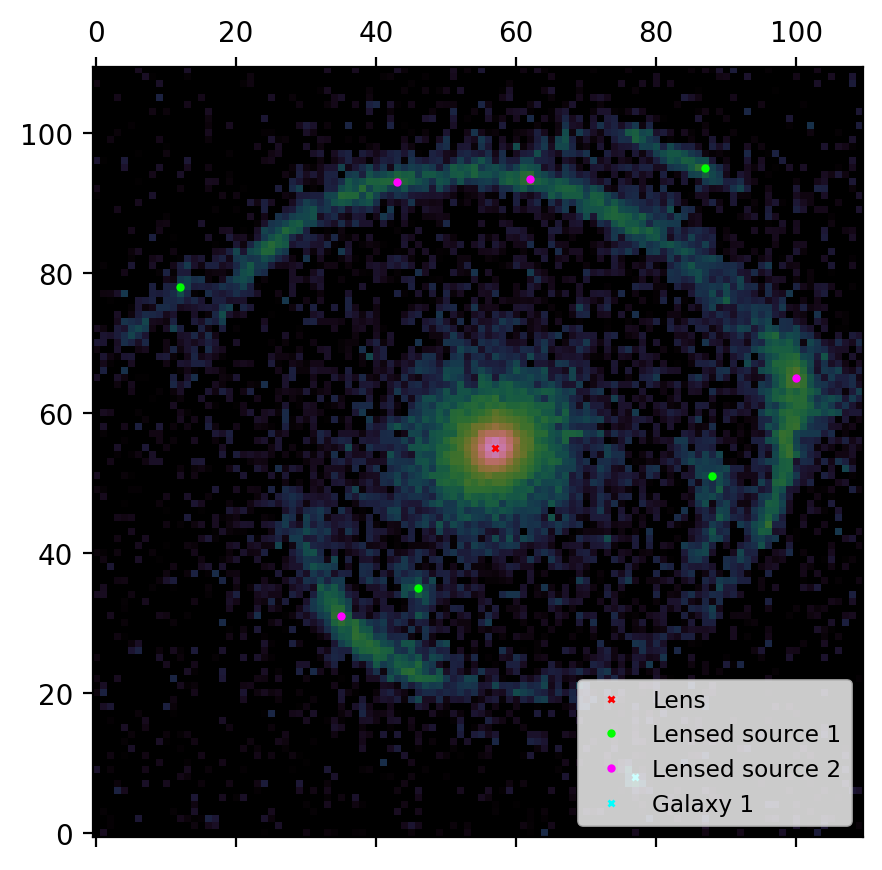

In [4]:
# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F200LP['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F200LP['dec_at_xy_0']
transform_pix2angle = kwargs_data_F200LP['transform_pix2angle']
coords_F200LP = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
image_data = kwargs_data_F200LP['image_data']
numPix = len(image_data)
deltaPix = coords_F200LP.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
print()

cmap = sns.cubehelix_palette(start=0.6, rot=-1.7, gamma=1, hue=1, light=-.7, dark=0.7, as_cmap=True)
cmap.set_bad(color='k')
ax = plt.figure(figsize=(5,5), dpi=200).gca()
ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-3.8, vmax=0.5)

kwargs_pixel_F200LP = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid_F200LP = PixelGrid(**kwargs_pixel_F200LP)
# plot_util.coordinate_arrows(ax, d=200, coords=pixel_grid, color='red', font_size=18, arrow_size=0.035)

# estimate lens position in pixel
lens_x_F200LP, lens_y_F200LP = 57, 55
lens_ra_F200LP, lens_dec_F200LP = coords_F200LP.map_pix2coord(lens_x_F200LP, lens_y_F200LP)
ax.plot(lens_x_F200LP, lens_y_F200LP, 'x', color='red', ms = 2, label='Lens') 

# estimate source 1 positions in pixel
s1_x_F200LP = np.array([87,12,88,46])#,77])
s1_y_F200LP = np.array([95,78,51,35])#,100])
ra_image_s1_F200LP, dec_image_s1_F200LP = coords_F200LP.map_pix2coord(s1_x_F200LP, s1_y_F200LP)
ax.plot(s1_x_F200LP, s1_y_F200LP, 'o', color='lime', ms = 2, label='Lensed source 1')

# estimate source 2 positions in pixel
s2_x_F200LP = np.array([100,35,62,43])
s2_y_F200LP = np.array([65,31,93.5,93])
ra_image_s2_F200LP, dec_image_s2_F200LP = coords_F200LP.map_pix2coord(s2_x_F200LP, s2_y_F200LP)
ax.plot(s2_x_F200LP, s2_y_F200LP, 'o', color='magenta', ms = 2, label='Lensed source 2')

# estimate galaxy position in pixel
gal1_x_F200LP, gal1_y_F200LP = 77, 8
gal1_ra_F200LP, gal1_dec_F200LP = coords_F200LP.map_pix2coord(gal1_x_F200LP, gal1_y_F200LP)
ax.plot(gal1_x_F200LP, gal1_y_F200LP, 'x', color='cyan', ms = 2, label='Galaxy 1') 

plt.legend(loc='lower right', fontsize='small')
plt.show()

Pixel size: 0.08 arcsec
numPix: 68



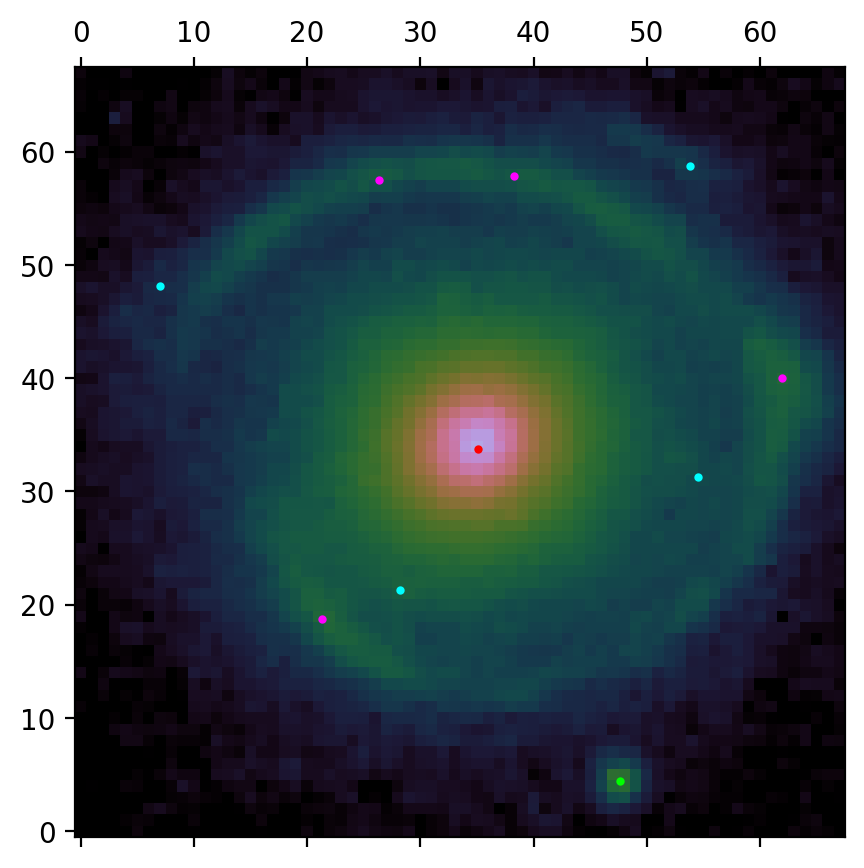

In [5]:
# read-in the coordiante system of the exposure
ra_at_xy_0 = kwargs_data_F140W['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_F140W['dec_at_xy_0']
transform_pix2angle = kwargs_data_F140W['transform_pix2angle']
coords_F140W = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
image_data = kwargs_data_F140W['image_data']
numPix = len(image_data)
deltaPix = coords_F140W.pixel_width
print('Pixel size: {:.2f} arcsec'.format(deltaPix))
print('numPix:', numPix)
print()

cmap2 = sns.cubehelix_palette(start=0.6, rot=-1.7, gamma=1, hue=1, light=-.6, dark=0.7, as_cmap=True)
ax = plt.figure(figsize=(5,5), dpi=200).gca()
ax.matshow(np.log10(image_data), origin='lower', cmap=cmap2, vmin=-3.5, vmax=1.3)

kwargs_pixel_F140W = {'nx': numPix, 'ny': numPix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 

pixel_grid_F140W = PixelGrid(**kwargs_pixel_F140W)
#plot_util.coordinate_arrows(ax, d=120, coords=pixel_grid, color='red', font_size=12, arrow_size=0.025)

# estimate lens position in pixel
lens_ra_F140W, lens_dec_F140W = lens_ra_F200LP+kwargs_data_F140W['ra_shift'], lens_dec_F200LP+kwargs_data_F140W['dec_shift']
lens_x_F140W, lens_y_F140W = coords_F140W.map_coord2pix(lens_ra_F140W, lens_dec_F140W)
ax.plot(lens_x_F140W, lens_y_F140W, 'o', color='red', ms = 2, label='Primary Lens') 

# estimate source 1 positions in pixel
ra_image_s1_F140W, dec_image_s1_F140W = ra_image_s1_F200LP+kwargs_data_F140W['ra_shift'], dec_image_s1_F200LP+kwargs_data_F140W['dec_shift']
s1_x_F140W, s1_y_F140W = coords_F140W.map_coord2pix(ra_image_s1_F140W, dec_image_s1_F140W)
ax.plot(s1_x_F140W, s1_y_F140W, 'o', color='cyan', ms = 2, label='Lensed Source 1')

# estimate source 2 positions in pixel
ra_image_s2_F140W, dec_image_s2_F140W = ra_image_s2_F200LP+kwargs_data_F140W['ra_shift'], dec_image_s2_F200LP+kwargs_data_F140W['dec_shift']
s2_x_F140W, s2_y_F140W = coords_F140W.map_coord2pix(ra_image_s2_F140W, dec_image_s2_F140W)
ax.plot(s2_x_F140W, s2_y_F140W, 'o', color='magenta', ms = 2, label='Lensed Source 2')

# estimate galaxy position in pixel
gal1_ra_F140W, gal1_dec_F140W=gal1_ra_F200LP+kwargs_data_F140W['ra_shift'], gal1_dec_F200LP+kwargs_data_F140W['dec_shift']
gal1_x_F140W,gal1_y_F140W=coords_F140W.map_coord2pix(gal1_ra_F140W, gal1_dec_F140W)
ax.plot(gal1_x_F140W,gal1_y_F140W, 'o', color='lime', ms = 2, label='Secondary Lens 1') 

# plt.legend(loc='upper left', fontsize='small', framealpha=0.9)
plt.show()

/tmp/ipykernel_81730/4153352153.py:66: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image_data*mask), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)
/tmp/ipykernel_81730/4153352153.py:66: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_data*mask), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)
/tmp/ipykernel_81730/4153352153.py:73: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)


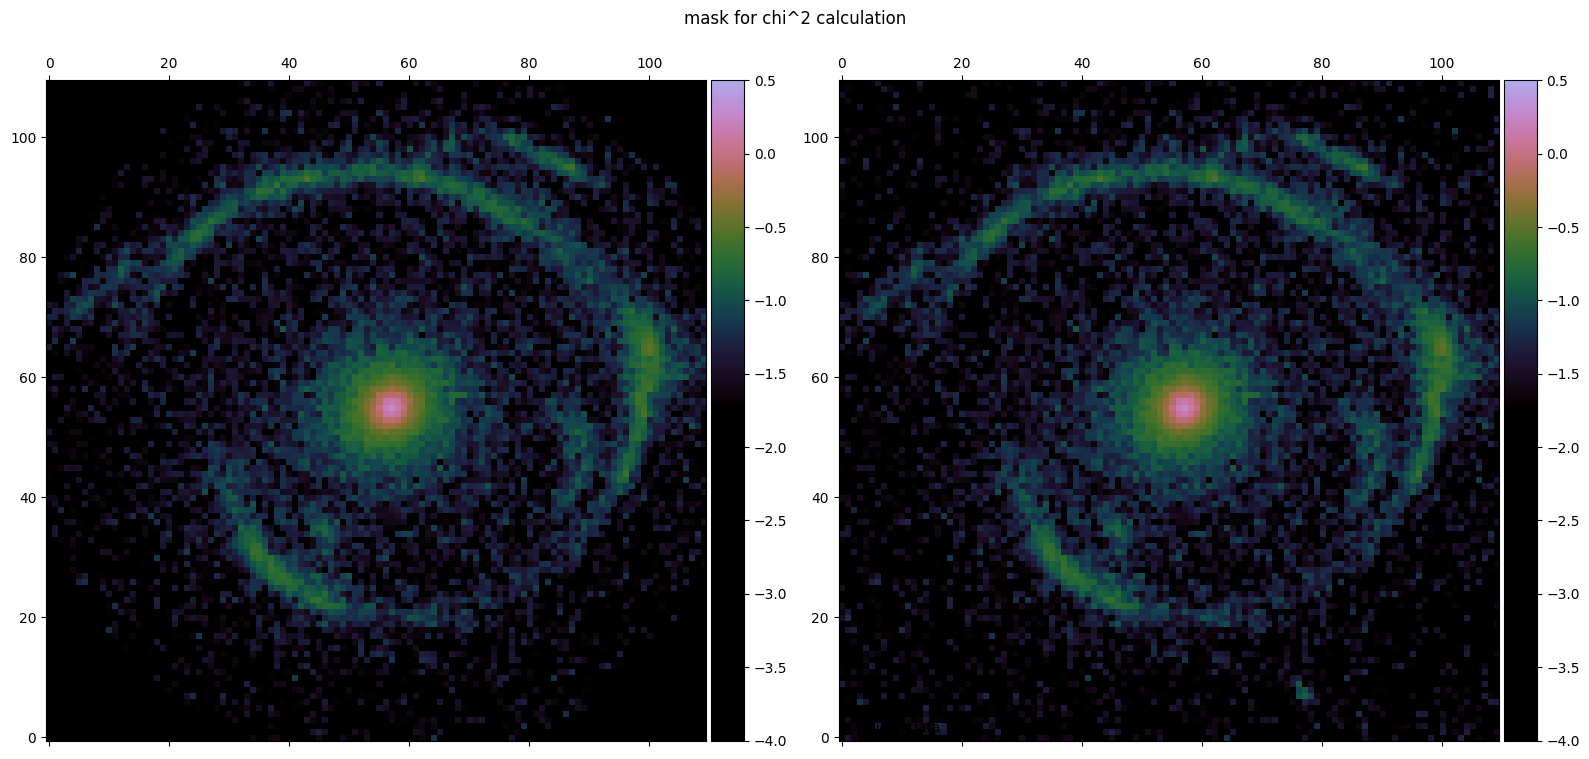

In [13]:
# creating mask
central_mask = False
central_mask_r = 1

# radius of circular aperture
r_mask_list = [[3]]  # list of mask radii for each mask band and filters eg [[filter1_rad1, filter1_rad2], [filter2_rad1, filter2_rad2]]

mask_list = []
index_mask_list = []

# lopping over no of bands
for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    # lopping over no of filters
    for j, kwargs_data in enumerate([kwargs_data_F200LP]): 
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        r = r_mask_list[j][i]
        mask_outer = mask_util.mask_center_2d(lens_ra_F200LP, lens_dec_F200LP, r, util.image2array(x_coords), util.image2array(y_coords))
        index_mask = 1 - mask_util.mask_center_2d(lens_ra_F200LP, lens_dec_F200LP, r, util.image2array(x_coords), util.image2array(y_coords))
        corona = mask_util.mask_center_2d(lens_ra_F200LP, lens_dec_F200LP, central_mask_r, util.image2array(x_coords), util.image2array(y_coords))
        
        # masking out second source
        mask_arc1 = mask_util.mask_half_moon(util.image2array(x_coords)-0.24, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 1.55, 2.1, phi0=-0.1, delta_phi=1 * np.pi)
        mask_arc2 = mask_util.mask_half_moon(util.image2array(x_coords)+0.155, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 1.85, 2.35, phi0=np.pi, delta_phi=0.84 * np.pi)
        mask_arc3 = mask_util.mask_half_moon(util.image2array(x_coords)+0.155, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 1.85, 2.35, phi0=-np.pi, delta_phi=0.7 * np.pi)
        mask_arc4 = mask_util.mask_half_moon(util.image2array(x_coords)-0.22, util.image2array(y_coords)-0.05, lens_ra_F200LP, lens_dec_F200LP, 1.6, 2.4, phi0=0.52*np.pi, delta_phi=0.28 * np.pi)
        mask_gal1 = 1 - mask_util.mask_center_2d(gal1_ra_F200LP, gal1_dec_F200LP, 0.1, util.image2array(x_coords), util.image2array(y_coords))
        #mask_arc5 = mask_util.mask_half_moon(util.image2array(x_coords)+1, util.image2array(y_coords)-0.5, lens_ra_F200LP, lens_dec_F200LP, 2.0, 2.47, phi0=-0.84*np.pi, delta_phi=0.15 * np.pi)
        #mask_arc6 = mask_util.mask_half_moon(util.image2array(x_coords)-0.22, util.image2array(y_coords)-0.5, lens_ra_F200LP, lens_dec_F200LP, 1.05, 1.55, phi0=0.42*np.pi, delta_phi=0.38 * np.pi)

        mask = (1 - mask_outer) * (1 - mask_gal1)#* (1 - mask_arc1) * (1 - mask_arc2) * (1 - mask_arc3) * (1 - mask_arc4) * (1 - mask_arc5) * (1 - mask_arc6)
    
        # when modeling both sources    
        #mask = (1 - mask_outer) # now modeling both sources

        if central_mask:
            mask *= corona
        
        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        index_mask_bands.append(index_mask)
        
    mask_list.append(mask_bands)
    index_mask_list.append(index_mask_bands)
    
for j, kwargs_data in enumerate([kwargs_data_F200LP]):
    image_data = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[0])+1, figsize=(16, 8), sharex=False, sharey=False)
    for i in range(len(r_mask_list[0])):
        ax = axes[i]
        
        mask = mask_list[0][j]
        
        plt.suptitle('mask for chi^2 calculation')
        im = ax.matshow(np.log10(image_data*mask), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax = axes[i+1]
        im = ax.matshow(np.log10(image_data), origin='lower', cmap=cmap, vmin=-4, vmax=0.5)
        ax.text(1, 1, 'reduced data')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.tight_layout()
        plt.show()

/tmp/ipykernel_81730/4174339806.py:24: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(image*mask), origin='lower', cmap='magma')


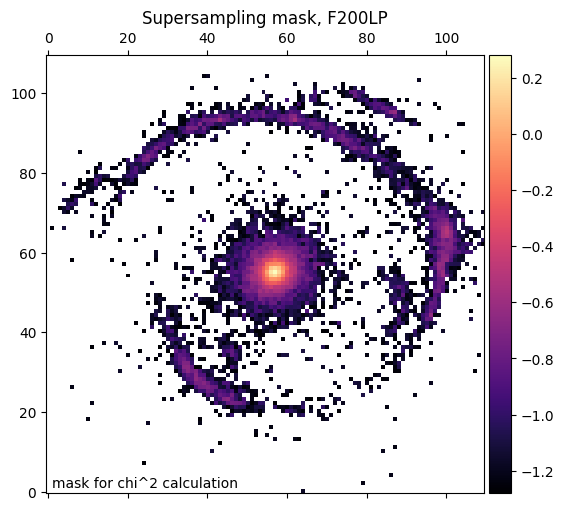

In [14]:
# pixels with flux > max_flux/threshold will not be supersampled
# here the threshold accepts pixels within 5 magnitude from the pixel with max_flux
threshold_list = [10**(3.9/2.5)]

supersampling_mask = []

for j, kwargs_data in enumerate([kwargs_data_F200LP]):
    s_mask = np.ones_like(kwargs_data['image_data'])
    
    max_flux = np.max(kwargs_data['image_data'])
    s_mask[kwargs_data['image_data'] < max_flux/threshold_list[j]] = 0
    
    supersampling_mask.append(s_mask)

filters = ['F200LP']

for j, kwargs_data in enumerate([kwargs_data_F200LP]):
    image = kwargs_data['image_data']
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)

    mask = supersampling_mask[j]*mask_list[0][j]
    im = ax.matshow(np.log10(image*mask), origin='lower', cmap='magma')
    ax.text(1, 1, 'mask for chi^2 calculation')
    ax.autoscale(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.set_title("Supersampling mask, "+filters[j])
    plt.colorbar(im, cax=cax)

    plt.show()

In [15]:
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3, Ob0=0.05)

#z_lens = 0.594
# Dominique and Lise claim 2.27 for the qso and 2.35 for the other blob.
#z_source_1 = 2.164
#z_source_2 = 2.6

z_l = 0.617
z_s1 = 1.46
z_s2 = 1.675

D_s1 = cosmo.angular_diameter_distance(z_s1).value
D_s2 = cosmo.angular_diameter_distance(z_s2).value
D_s1s2 = cosmo.angular_diameter_distance_z1z2(z_s1, z_s2).value
D_ls1 = cosmo.angular_diameter_distance_z1z2(z_l, z_s1).value
D_ls2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s2).value

#cosmological scaling factor=deflection_scaling= 1/β
deflection_scaling = D_s1 / D_ls1 * D_ls2 / D_s2  
beta=1/deflection_scaling
print('Angular diameter distance between s1 and s2: {} Mpc'.format(D_s1s2))
print('Deflection angle rescale factor: {:.6f}'.format(deflection_scaling))
print('Beta:{:.6f}'.format(beta))

Angular diameter distance between s1 and s2: 143.3154940018939 Mpc
Deflection angle rescale factor: 1.091248
Beta:0.916382


In [16]:
# lens model settings
lens_bound = 0.05 # bound for lens position from the initial position

shear = True  # adding of a external shear component in the model
add_nearby_galaxy = True # True will add nearby galaxy's mass to the lens model

lens_center_ra, lens_center_dec = lens_ra_F200LP, lens_dec_F200LP

# gal1_center_x, gal1_center_y = gal1_ra_F140W, gal1_dec_F140W
# gal_bound = 0.05

shapelet_beta = 0.15 # initial guess of the shapelet scale (in arcsec)

source_bound = 0.15 

In [17]:
lens_redshift_list = [z_l, z_l, z_s1]
lens_model_list = ['EPL', 'SHEAR_GAMMA_PSI', 'SIE']

kwargs_lens_init = [{'theta_E': 1.9237814207588908,
   'gamma': 2,
   'e1': 0.08359457749304137,
   'e2': 0.06915961401589485,
   'center_x': 0.0480714876311244,
   'center_y': -0.026121787848657426},
  {'gamma_ext': 0.11915106152231696,
   'psi_ext': 0.5038232369170116,
   'ra_0': 0,
   'dec_0': 0},
  {'theta_E': 0.22912598136750414,
   'e1': 0.4371870389197965,
   'e2': -0.10569696047809995,
   'center_x': 0.7807419979440894,
   'center_y': -0.8692051279779364}]

kwargs_lens_sigma = [{'theta_E': 0.1, 'gamma': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y':0.01},
                     {'gamma_ext': 0.01, 'psi_ext': 0.01}, 
                     {'theta_E': 0.1, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y':0.01}
                     ]

kwargs_lower_lens = [{'theta_E': 1, 'gamma': 1.5, 'e1': -0.25, 'e2': -0.25,'center_x': -10,'center_y': -10},
                     {'gamma_ext': 0.0, 'psi_ext': 0.0},
                     {'theta_E': 0.001, 'e1': -0.25, 'e2': -0.25,'center_x': -10,'center_y': -10}
                     ]

kwargs_upper_lens = [{'theta_E': 6.0, 'gamma': 3, 'e1': 0.25, 'e2': 0.25, 'center_x': 10, 'center_y':10},
                     {'gamma_ext': 0.2, 'psi_ext': np.pi},
                     {'theta_E': 0.5, 'e1': 0.25, 'e2': 0.25, 'center_x': 10, 'center_y':10}
                     ]

# fixed parameters for each model in list
kwargs_lens_fixed = [{'gamma': 2},
                     {'ra_0': 0,'dec_0': 0},
                     {}
                     ]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]

In [18]:
lens_light_model_list = ['SERSIC_ELLIPSE']


kwargs_lens_light_init = [{'R_sersic': 2.706534933472987,
   'n_sersic': 6.004395416781097,
   'e1': 0.07272692388125464,
   'e2': -0.05016224651622911,
   'center_x': 0.0924272489079676,
   'center_y': 0.014598295432563597}]

kwargs_lens_light_sigma = [{'R_sersic': 0.1,'n_sersic': 0.1, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.005, 'center_y': 0.005}]

kwargs_lower_lens_light = [{'R_sersic': 0.5,'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x':lens_center_ra-lens_bound, 'center_y': lens_center_dec-lens_bound}]

kwargs_upper_lens_light = [{'R_sersic': 10,'n_sersic': 10, 'e1': 0.5, 'e2': 0.5,'center_x': lens_center_ra+lens_bound, 'center_y': lens_center_dec+lens_bound}]

kwargs_lens_light_fixed = [{}] 

#index_lens_light_model_list = [[0,1,2,3], [4,5,6,7]]  # first 4 profiles set to band 1, last 4 set to band 2  # turn on for multi-band

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]


In [19]:
source_redshift_list = [z_s1, z_s2, z_s2]  # turn on for double source

source_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

image_plane_source_list = [False, False, False]   # turn on for double source

kwargs_source_init = [{'R_sersic': 0.2035989518818442,
   'n_sersic': 1.8792552215500815,
   'e1': 0.4371870389197965,
   'e2': -0.10569696047809995,
   'center_x': 0.7807419979440894,
   'center_y': -0.8692051279779364},
  {'R_sersic': 0.11098111524947607,
   'n_sersic': 0.5251575461491514,
   'e1': 0.497834080242937,
   'e2': -0.11661295352147125,
   'center_x': -0.351038921186534,
   'center_y': -0.4640522531075717},
  {'R_sersic': 0.19362063802763319,
   'n_sersic': 0.9945376617604998,
   'e1': 0.3888323276915802,
   'e2': -0.339222236571743,
   'center_x': 0.3773625720089029,
   'center_y': -0.41000035597773105}]

kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1,'e1':  0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1},
                       {'R_sersic': 0.1, 'n_sersic': 0.1,'e1':  0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1},
                       {'R_sersic': 0.1, 'n_sersic': 0.1,'e1':  0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1}
                       ]

kwargs_lower_source = [{'R_sersic': 0.005, 'n_sersic': 0.5, 'e1':  -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10},
                       {'R_sersic': 0.005, 'n_sersic': 0.5,'e1':  -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10},
                       {'R_sersic': 0.005, 'n_sersic': 0.5,'e1':  -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}
                       ]

kwargs_upper_source = [{'R_sersic': 0.3, 'n_sersic': 10,'e1':  0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10},
                       {'R_sersic': 0.3, 'n_sersic': 10,'e1':  0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10},
                       {'R_sersic': 10, 'n_sersic': 10,'e1':  0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}
                       ]

kwargs_source_fixed = [{},
                       {},
                       {}
                       ]

#index_source_light_model_list = [[0,1,2], [3,4,5]]  # first 3 profiles set to band 1, last 3 set to band 2  # turn on for multi-band

source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]

In [20]:
point_source_list = []

kwargs_ps_init = []
kwargs_ps_sigma = []
kwargs_lower_ps = []
kwargs_upper_ps = []
kwargs_ps_fixed = []

ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

In [21]:
def custom_logL_function(kwargs_lens=None, kwargs_source=None, 
                                 kwargs_lens_light=None, kwargs_ps=None, 
                                 kwargs_special=None, kwargs_extinction=None,
                                 kwargs_tracer_source=None):
    
    logL = 0.
    bound = 30. / 180. * np.pi

    # PA constraint
    # find e1 & e2 param., convert to PA (phi)
    mass_phi, mass_q = ellipticity2phi_q(kwargs_lens[0]['e1'], kwargs_lens[0]['e2'])
    light_phi, light_q = ellipticity2phi_q(kwargs_lens_light[0]['e1'], kwargs_lens_light[0]['e2'])

    # ellipticity prior to reduce disparity between mass and light
    if mass_q < light_q:  
        logL += -0.5 * (mass_q - light_q)**2 / 0.01**2
    logL += -0.5 * (mass_phi - light_phi)**2 / bound**2

    # lens centre prior
    lens_center_x, lens_center_y = 0.09789233337522507, 0.020403937171283193  # visually measured centre
    logL -= ((kwargs_lens[0]['center_x'] - lens_center_x)**2 + (kwargs_lens[0]['center_y'] - lens_center_y)**2)*10

    return logL

In [ ]:
kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params
                }

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
                'point_source_model_list': point_source_list,
                'additional_images_list': None,
                'fixed_magnification_list':None,  # If True, magnification ratio of point sources is fixed to the one given by the lens model 
                'multi_plane': True,  # turn on for double source
                'lens_redshift_list': lens_redshift_list,  # turn on for double source
                'cosmo': cosmo,  # turn on for double source
                'z_source': z_s2,  # turn on for double source
                'source_redshift_list': source_redshift_list,  # turn on for double source
                #'index_source_light_model_list': index_source_light_model_list,  # turn on for multi-band
                #'index_lens_light_model_list': index_lens_light_model_list  # turn on for multi-band
               }

kwargs_numerics = {'supersampling_factor':3,  # use 3 for final runs                              
                   'supersampling_convolution':True, 
                   'supersampling_kernel_size': 11,
                   'flux_evaluate_indexes': None,
                   'point_source_supersampling_factor': 3,  # use 3 for final runs
                   'compute_mode': 'adaptive',
                   'supersampled_indexes': np.array(supersampling_mask[0]*mask_list[0][0], dtype=bool)
                   }

# for multi-band
# kwargs_numerics_F200LP = {'supersampling_factor':3,  # use 3 for final runs                              
#                    'supersampling_convolution':True, 
#                    'supersampling_kernel_size': 11,
#                    'flux_evaluate_indexes': None,
#                    'point_source_supersampling_factor': 3,  # use 3 for final runs
#                    'compute_mode': 'adaptive',
#                    'supersampled_indexes': np.array(supersampling_mask[1]*mask_list[0][1], dtype=bool)
#                    }

num_source_model = len(source_model_list)

# tied parameters
kwargs_constraints = {'image_plane_source_list': image_plane_source_list,  # turn on for double source
                      #'joint_source_with_source':[[0,1,['center_x','center_y']],
                                                  #[3,4,['center_x','center_y']]],
                      #'joint_lens_with_light':[[0,0,['center_x','center_y']]],  # first index: lens light, second index: mass
                                            #    [4,0,['center_x','center_y','e1','e2']],
                                            #    [2,2,['center_x','center_y']],
                                            #    [6,2,['center_x','center_y']],
                                            #    [3,3,['center_x','center_y','e1','e2']],
                                            #    [7,3,['center_x','center_y','e1','e2']]],
                    #   'joint_lens_light_with_lens_light':[[0,1,['center_x','center_y']],
                    #                                       [4,5,['center_x','center_y']]],
                       'joint_lens_with_source_light':[[0,2,['center_x','center_y','e1','e2']]]
                                                      #[2,3,['center_x','center_y','e1','e2']]]  # first index :source, second index mass
                      }


kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': True,
                     'image_position_uncertainty': 0.001,
                     'image_position_likelihood':True,  # turn on for double source
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'bands_compute':[True],
                     'check_positive_flux':True,
                     'image_likelihood_mask_list':  mask_list[0],
                     'custom_logL_addition': custom_logL_function,
                     'astrometric_likelihood':True
                     }



In [23]:
# F140W_band = [kwargs_data_F140W, kwargs_psf_F140W, kwargs_numerics_F140W]
F200LP_band = [kwargs_data_F200LP, kwargs_psf_F200LP, kwargs_numerics]
multi_band_list = [F200LP_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [29]:
fitting_kwargs_list = [#['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True]}}],
                       #['PSO', {'sigma_scale': 10, 'n_particles': 220, 'n_iterations': 3000}],
                       ['PSO', {'sigma_scale': 1, 'n_particles': 1, 'n_iterations': 10}],
                       #['PSO', {'sigma_scale': 0.5, 'n_particles': 220, 'n_iterations': 2000}],
                       #['PSO', {'sigma_scale': 0.1, 'n_particles': 220, 'n_iterations': 2000}],
                       #['MCMC', {'n_burn': 100, 'n_run': 3000, 'walkerRatio': 6, 'sigma_scale': 0.5}]
                       ]

In [30]:
def update_init(old, new):  # from old to new
    for i, (o, n) in enumerate(zip(old, new)):
        for key, value in o.items():
            if key in n:
                n[key] = value

    return new

In [31]:
def configure_model(job_name, fitting_kwargs_list=fitting_kwargs_list, kwargs_params=kwargs_params, cluster_compute=False, use_good_start=False, prev_job_name=None, reuse_samples=False, prev_file_dir=None, verbose=False):   
    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'

    # load previous job result as starting point
    if use_good_start:

        if prev_job_name is None:
            raise ValueError
        job_name_old =  prev_job_name
        
        if prev_file_dir is None:
            raise ValueError
        
        output_temp_old = os.path.join(base_path, prev_file_dir, job_name_old +'_out.txt') #'local_temp'

        f = open(output_temp_old, 'rb')
        [input_, output_] = joblib.load(f)
        f.close()

        old_fitting_kwargs_list, kwargs_data_joint_out, _, _, _, _, _ = input_
        kwargs_result, multi_band_list_out, fit_output, _ = output_
        lens_result = kwargs_result['kwargs_lens']
        source_result = kwargs_result['kwargs_source']
        lens_light_result = kwargs_result['kwargs_lens_light']
        ps_result = kwargs_result['kwargs_ps']
        #special_result= kwargs_result['kwargs_special']

        # updating init kwargs
        lens_params[0] = update_init(lens_result, lens_params[0])       
        source_params[0] = update_init(source_result, source_params[0]) 
        lens_light_params[0] = update_init(lens_light_result, lens_light_params[0])
        ps_params[0] = update_init(ps_result, ps_params[0])
        #special_params[0] =special_result 
    
        # updating kwargs that will be input into fitting sequence
        kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params,
                    #'special': special_params
                    }
        
        if verbose:
            print('updated lens_params',lens_params)
            print('\n updated source_params',source_params)
            print('\n updated lens_light_params',lens_light_params)
            print('\n updated ps_params',ps_params)
            #print('\n updated special_params',special_params)
        
        # using prev mcmc sapmples for next mcmc
        if reuse_samples:
            samples_mcmc = fit_output[-1][1] #mcmc chain from prev_job_name
            
            n_params = samples_mcmc.shape[1]

            n_walkers = old_fitting_kwargs_list[-1][1]['walkerRatio'] * n_params
            n_step = int(samples_mcmc.shape[0] / n_walkers)

            print('MCMC settings from last chain: ', n_step, n_walkers, n_params)

            chain = np.empty((n_walkers, n_step, n_params))
            
            for i in np.arange(n_params):
                samples = samples_mcmc[:, i].T
                chain[:,:,i] = samples.reshape((n_step, n_walkers)).T
            
            init_samples = chain[:, -1, :]
            #print(np.shape(init_samples))
            #print(init_samples)
            print('Init MCMC samples from: ', prev_job_name)
            print('Init samples shape: ', init_samples.shape)
            
        else:
            init_samples = None

        # updating kwargs that will be input into fitting sequence  
        fitting_kwargs_list=[['update_settings', {'kwargs_likelihood': {'bands_compute': [True]}}],
                             #['PSO', {'sigma_scale': 0.1, 'n_particles': 250, 'n_iterations': 500}],
                        #['MCMC', {'n_burn': 100, 'n_run': 4000, 'walkerRatio': 8, 'sigma_scale': .1}]
                ['MCMC', {'n_burn': 0, #mcmc_n_burn, 
                          'n_run':3000, #mcmc_n_run, 
                          'walkerRatio': 6, 
                          'sigma_scale': 0.5,
                          're_use_samples': True, 
                          'init_samples': init_samples}]
                        ]
        if verbose:
            print('updated fitting_kwargs_list', fitting_kwargs_list)
    
    if cluster_compute is True:
        path2input_temp = os.path.join(base_path, 'midway_temp', input_temp)
        dir_path_cluster = '/pool/public/sao/dbowden/Compound/DCLS0353'
        path2input_cluster = os.path.join(dir_path_cluster, 'local_temp', input_temp)

        f = open(path2input_temp,'wb')
        pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
        f.close()
        time.sleep(2)

        # copying .txt to remote cluster with model and fitting info
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=None, username=None, password=None) 
        ftp_client = ssh_client.open_sftp()
        ftp_client.put(path2input_temp, path2input_cluster)
        ftp_client.put(base_path+'/jobs/DCLS0353_double_source_F200LP_V18.job', dir_path_cluster+'/DCLS0353_double_source_F200LP_V18.job')  # update job file before executing this
        ftp_client.close()
        ssh_client.close()

        print('File %s uploaded to cluster' %path2input_cluster)
        print('Must run job on cluster with jobname {} and job file {}'.format(job_name, job_name[:-7]+'.job'))
    else:
        path2input_temp = os.path.join(base_path, 'local_temp', input_temp)

        f = open(path2input_temp,'wb')
        pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
        f.close()
        time.sleep(2)

        start_time = time.time()
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False, verbose=True)
    
        fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit(bijective=False)
        multi_band_list_out = fitting_seq.multi_band_list
        
        kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs  
        #kwargs_fixed_out = fitting_seq.kwargs_fixed
        #param_class = fitting_seq.param_class
        output_ = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

        input_ = [fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        path2dump = os.path.join(base_path, 'local_temp', output_temp)
        f = open(path2dump, 'wb')
        joblib.dump([input_, output_], f)
        f.close()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('Result saved in: %s' % path2dump)
        print('============ CONGRATULATIONS, YOUR JOB WAS SUCCESSFUL ================ ')

        return fitting_seq 

In [32]:
job_name = 'PSO_double_source_test'

cluster_comp = False

In [33]:
configure_model(job_name, cluster_compute=cluster_comp)

Computing the PSO ...


  0%|          | 0/10 [00:00<?, ?it/s]/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 10/10 [00:01<00:00,  8.38it/s]

Max iteration reached! Stopping.
-1.4054702678316315 reduced X^2 of best position
-7437.748657364994 log likelihood
10584 effective number of data points
[{'theta_E': 1.893041387747998, 'gamma': 2, 'e1': 0.08286040742757186, 'e2': 0.06822597897946027, 'center_x': 0.05095871518420002, 'center_y': -0.025478429056593938}, {'gamma_ext': 0.11788155914181021, 'psi_ext': 0.5050670369105281, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.2295908598396859, 'e1': 0.4378024046973327, 'e2': -0.10065037189698407, 'center_x': 0.8102710984472746, 'center_y': -0.867973135605603}] lens result
[{'amp': 1, 'R_sersic': 0.17608545584635504, 'n_sersic': 1.9189010258062575, 'e1': 0.4378024046973327, 'e2': -0.10065037189698407, 'center_x': 0.8102710984472746, 'center_y': -0.867973135605603}, {'amp': 1, 'R_sersic': 0.10913348556765895, 'n_sersic': 0.5527941167029581, 'e1': 0.4694319794363641, 'e2': -0.1341928505807632, 'center_x': -0.33971960156378533, 'center_y': -0.4442323422802481}, {'amp': 1, 'R_sersic': 0.17891274

In [ ]:
job_name_out = job_name+'_out.txt'  # 'DCLS0353_double_source_F200LP_V18_run_07_out.txt'

output_temp = os.path.join(base_path, 'local_temp', job_name_out)

path2dump = os.path.join(base_path, 'midway_temp', job_name_out)

if cluster_comp:

    if not os.path.exists(path2dump):  # If file does not exist, copy from cluster
        dir_path_cluster = '/pool/public/sao/dbowden/Compound/DCLS0353'
        path2dump_cluster = os.path.join(dir_path_cluster, 'local_temp', job_name_out)

        # copying results _out.txt from remote cluster
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=None, username=None, password=None) 
        ftp_client = ssh_client.open_sftp()
        ftp_client.get(path2dump_cluster, path2dump)
        ftp_client.close()
        ssh_client.close()

    f = open(path2dump, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()
    
else:    
    f = open(output_temp, 'rb')
    [input_, output_] = joblib.load(f)
    f.close()

fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:76: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(


-1.0349298159790201 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0349298159790206


/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/tmp/ipykernel_81730/1160269544.py:2: RuntimeWarning: invalid value encountered in log10
  plot = ax.imshow(np.log10(data), origin='lower', cmap=c_map,vmin=v_min,vmax=v_max)
/tmp/ipykernel_81730/1160269544.py:2: RuntimeWarning: divide by zero encountered in log10
  plot = ax.imshow(np.log10(data), origin='lower', cmap=c_map,vmin=v_min,vmax=v_max)
/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:300: RuntimeWarning: invalid value encountered in log10
  np.log10(kappa_result),


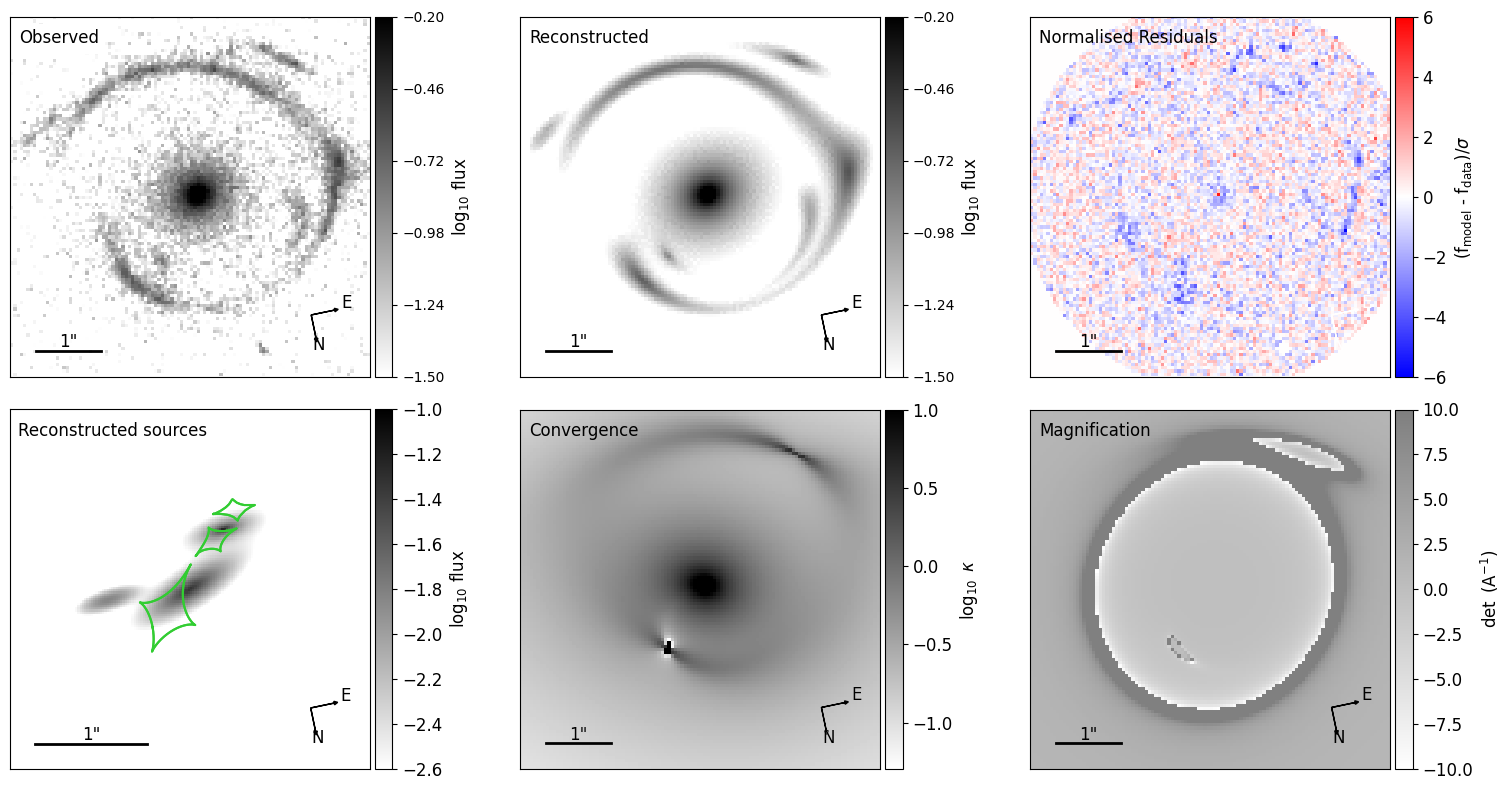

{'kwargs_lens': [{'theta_E': 1.9237814207588908,
   'gamma': 2.5204611045352494,
   'e1': 0.08359457749304137,
   'e2': 0.06915961401589485,
   'center_x': 0.0480714876311244,
   'center_y': -0.026121787848657426},
  {'gamma_ext': 0.11915106152231696,
   'psi_ext': 0.5038232369170116,
   'ra_0': 0,
   'dec_0': 0},
  {'theta_E': 0.22912598136750414,
   'e1': 0.4371870389197965,
   'e2': -0.10569696047809995,
   'center_x': 0.7807419979440894,
   'center_y': -0.8692051279779364}],
 'kwargs_source': [{'amp': 8.381483901310734,
   'R_sersic': 0.2035989518818442,
   'n_sersic': 1.8792552215500815,
   'e1': 0.4371870389197965,
   'e2': -0.10569696047809995,
   'center_x': 0.7807419979440894,
   'center_y': -0.8692051279779364},
  {'amp': 17.384798634865263,
   'R_sersic': 0.11098111524947607,
   'n_sersic': 0.5251575461491514,
   'e1': 0.497834080242937,
   'e2': -0.11661295352147125,
   'center_x': -0.351038921186534,
   'center_y': -0.4640522531075717},
  {'amp': 23.875920580385277,
   'R_

In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                      arrow_size=0.01, cmap_string='gray_r',
                      image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list']
                      )

#print(kwargs_model)
#print(kwargs_result)

f, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=False, sharey=False)

# data for custom plotting
image_data = kwargs_data_F200LP['image_data']
recon_F200LP = modelPlot._band_plot_list[0]._model
#source_recon = modelPlot.source(deltaPix=0.02, numPix=160, center=(kwargs_result['kwargs_lens'][0]['center_x'], kwargs_result['kwargs_lens'][0]['center_y']))

arraytosubplot(axes[0,0], image_data, pixel_grid_F200LP, 20, 'Observed', v_min=-1.5, v_max=-0.2)
arraytosubplot(axes[0,1], recon_F200LP, pixel_grid_F200LP, 20, 'Reconstructed', v_min=-1.5, v_max=-0.2)


modelPlot.normalized_residual_plot(ax=axes[0,2],font_size=12, text='')
plot_util.text_description(axes[0,2], 0.05*110,text='Normalised Residuals',color="k",backgroundcolor="None",font_size=12)

dPs = 0.02
nP = 160
modelPlot.source_plot(ax=axes[1, 0],font_size=12, deltaPix_source=dPs, numPix=nP, with_caustics=True,v_min=-2.6,v_max= -1,caustic_color="limegreen", center=(kwargs_result['kwargs_source'][2]['center_x'], kwargs_result['kwargs_source'][2]['center_y']), text='')
plot_util.text_description(axes[1,0], dPs*nP,text='Reconstructed sources',color="k",backgroundcolor="w",font_size=12)
plot_util.scale_bar(axes[1,0], dPs*nP, dist=1, text='1"', font_size=12, color='k')
plot_util.coordinate_arrows(axes[1,0], dPs*nP, pixel_grid_F200LP, color="k", arrow_size=0.01, font_size=12)

modelPlot.convergence_plot(ax=axes[1, 1],font_size=12, v_max=1, text='')
plot_util.text_description(axes[1,1], 0.05*110,text='Convergence',color="k",backgroundcolor="None",font_size=12)
plot_util.scale_bar(axes[1,1], 0.05*110, dist=1, text='1"', font_size=12, color='k')
plot_util.coordinate_arrows(axes[1,1], 0.05*110, pixel_grid_F200LP, color="k", arrow_size=0.01, font_size=12)

modelPlot.magnification_plot(ax=axes[1, 2],font_size=12, text='')
plot_util.text_description(axes[1,2], 0.05*110,text='Magnification',color="k",backgroundcolor="None",font_size=12)

plt.tight_layout()
plt.savefig(fname='results/'+job_name_out[:-8]+'.pdf')
plt.show()

kwargs_result

/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(
/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:76: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(


-1.0349298159790201 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0349298159790206


/home/duncan/Lensing/lenstronomy1.12.4.venv/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:67: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


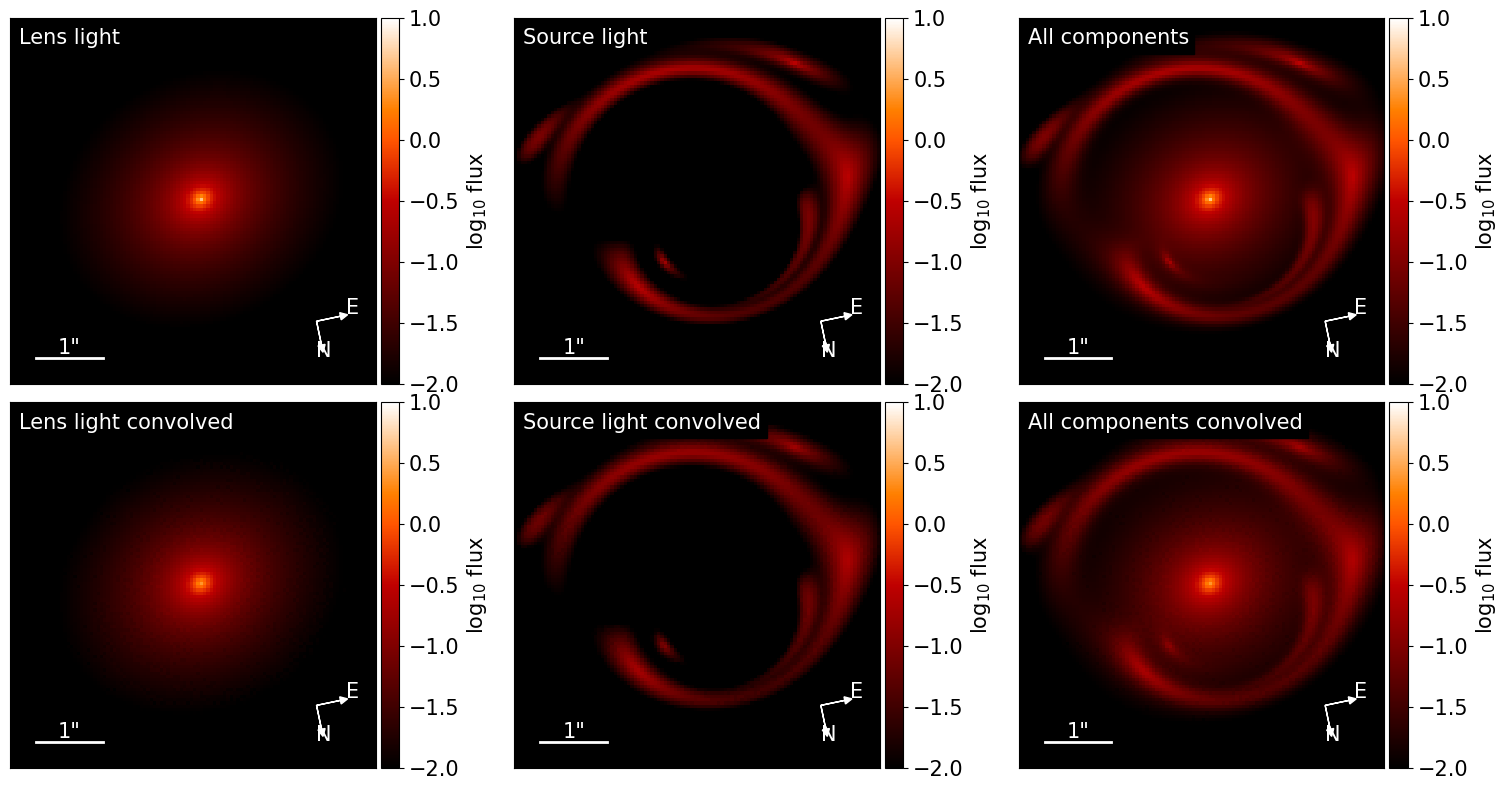

In [26]:
# band index to plot the model breakdown, 0: F140W, 1: F200LP
band_i = 0

lensPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, 
                     arrow_size=0.02, cmap_string="gist_heat",
                    image_likelihood_mask_list=kwargs_likelihood['image_likelihood_mask_list'], #kwargs_likelihood['image_likelihood_mask_list'],
                    multi_band_type='multi-linear', linear_solver = True
                    )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-2,v_max= 1) 
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True, band_index=band_i, v_min=-2,v_max=1) 

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


N_step: 3000, N_walkers: 198, N_params: 33
theta_E_lens0 1.9241 ± 0.0023
gamma_lens0 2.4959 ± 0.0276
e1_lens0 0.0797 ± 0.0068
e2_lens0 0.0672 ± 0.0060
center_x_lens0 0.0484 ± 0.0033
center_y_lens0 -0.0262 ± 0.0032
gamma_ext_lens1 0.1175 ± 0.0020
psi_ext_lens1 0.5005 ± 0.0122
theta_E_lens2 0.2378 ± 0.0154
R_sersic_source_light0 0.2063 ± 0.0363
n_sersic_source_light0 1.7901 ± 0.3406
e1_source_light0 0.4531 ± 0.0334
e2_source_light0 -0.0970 ± 0.0330
center_x_source_light0 0.7742 ± 0.0115
center_y_source_light0 -0.8572 ± 0.0161
R_sersic_source_light1 0.1140 ± 0.0055
n_sersic_source_light1 0.5496 ± 0.0484
e1_source_light1 0.4963 ± 0.0042
e2_source_light1 -0.1095 ± 0.0256
center_x_source_light1 -0.3443 ± 0.0179
center_y_source_light1 -0.4644 ± 0.0112
R_sersic_source_light2 0.1887 ± 0.0074
n_sersic_source_light2 0.9968 ± 0.0495
e1_source_light2 0.3909 ± 0.0091
e2_source_light2 -0.3396 ± 0.0148
center_x_source_light2 0.3752 ± 0.0080
center_y_source_light2 -0.4125 ± 0.0143
R_sersic_lens_light0 

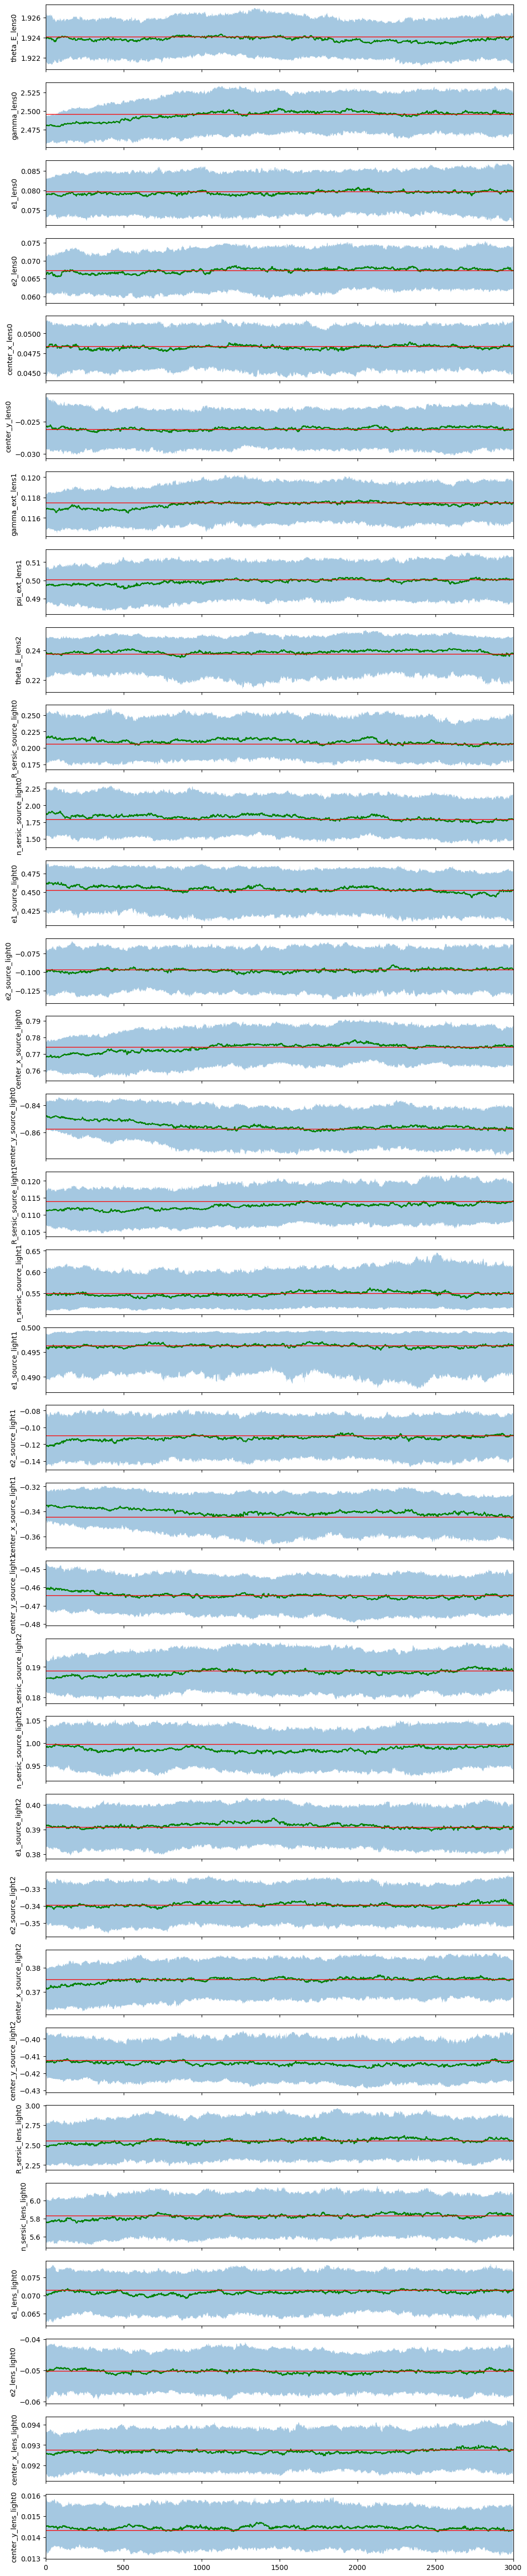

In [ ]:
samples_mcmc = []
samples_pso = []

if fit_output[-1][0] != 'PSO':
    # if MCMC chain was broken in the chunks, we join the chunks to make the full chain
    mcmc_repeat = 1
      
    for k in range(len(fit_output)-mcmc_repeat, len(fit_output)):
        if samples_mcmc == []:
            samples_mcmc = fit_output[k][1]
        else:
            samples_mcmc = np.vstack((samples_mcmc, fit_output[k][1]))

        param_mcmc = fit_output[k][2]

    MCMC = True

else:
    # if PSO chain was broken in the chunks, we join the chunks to make the full chain
    for k in range(0, len(fit_output)):
        if isinstance(samples_pso, list):  # if empty list
            samples_pso = fit_output[k][1][1]
            samples_pso = np.array(samples_pso)
        else:
            samples_pso = np.vstack((samples_pso, fit_output[k][1][1]))
    
    param_pso = fit_output[-1][2]

    MCMC = False
    
if MCMC:
    n_params = samples_mcmc.shape[1]

    n_walkers = fitting_kwargs_list[-1][1]['walkerRatio'] * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print('N_step: {}, N_walkers: {}, N_params: {}'.format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))

        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.show()

else:
    n_params = np.shape(samples_pso)[1]

    n_step = np.shape(samples_pso)[0]

    print('N_step: {}, N_params: {}'.format(n_step, n_params))

    chain = np.array(samples_pso)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    last = n_step

    for i in range(n_params):
        print(param_pso[i], chain[-1,i])

        ax[i].plot(chain[:,i], c='g')
        ax[i].set_ylabel(param_pso[i], fontsize=10)
        ax[i].set_xlim(-1, last)

    if True:
        fig.set_size_inches((12., 2*len(param_pso)))
        plt.show()

In [ ]:
# from datetime import date

# # writing comments
# comment = 'Continuing 08 with sigma 0.5. s1 image still off'
# np.savetxt('results/comments/'+'DCLS0353_double_source_F200LP_V18_run_11.txt', [job_name+' '+str(date.today()), comment], fmt='%s')

In [ ]:
# # only run the below if MCMC used

# sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = fit_output[-1]
    
# print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
# print("parameters in order: ", param_mcmc)
# print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
# import corner

# n, num_param = np.shape(samples_mcmc)
# #plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)

number of non-linear parameters in the MCMC process:  33
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'theta_E_lens2', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_source_light1', 'n_sersic_source_light1', 'e1_source_light1', 'e2_source_light1', 'center_x_source_light1', 'center_y_source_light1', 'R_sersic_source_light2', 'n_sersic_source_light2', 'e1_source_light2', 'e2_source_light2', 'center_x_source_light2', 'center_y_source_light2', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  594000


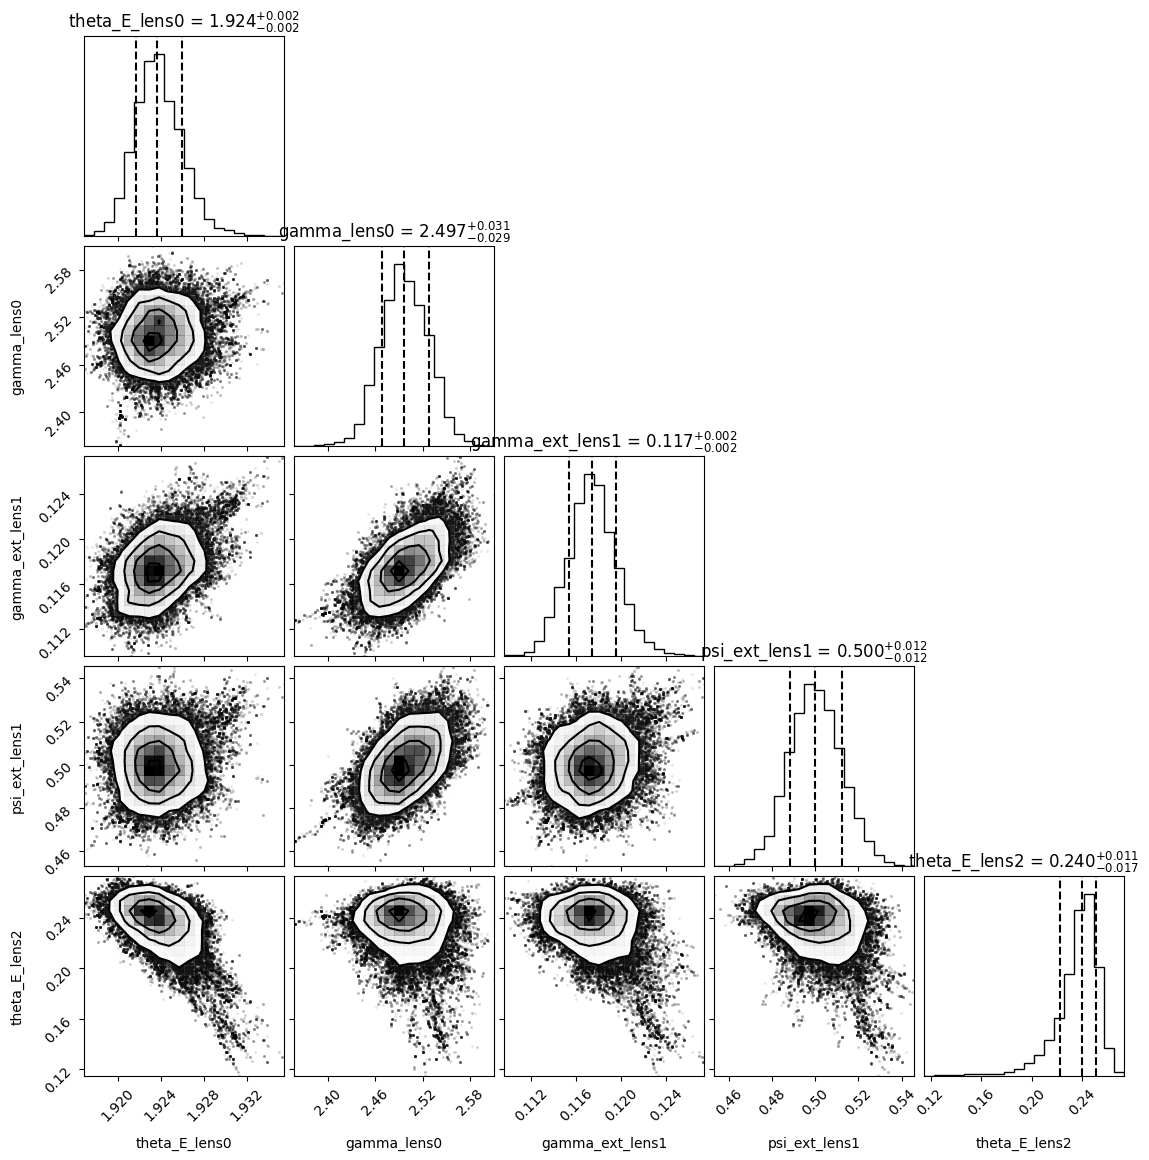

In [ ]:
# n_junk = 400000  # number of initial sample values to discard
# n_display_params = 2  # number of fitted params to plot

# sample = np.concatenate((samples_mcmc[n_junk:,:n_display_params], samples_mcmc[n_junk:,6:9]), axis=1) # selecting relevant sample parameters and values
# col_name = param_mcmc[:n_display_params] + param_mcmc[6:9]
# # sample = samples_mcmc[n_junk:,:n_display_params]  # selecting relevant sample parameters and values
# # col_name = param_mcmc[:n_display_params]
# figure = corner.corner(sample,color='k',
#                        labels=col_name,
#                        title_quantiles=[0.16, 0.5, 0.84],
#                        title_fmt=".3f",
#                        quantiles=[0.16, 0.5, 0.84],
#                        show_titles=True,
#                        smooth=0.5                    
#                        )